In [ ]:
# !pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
import shap
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modeling import FoldSet, GridSearch_ML, MLTest
from RNN_modeling import Make_DataSet
from correlation import Correlation
from visualization import Result_pred, Plot_Result

# Load data

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Mpdata.csv')
print(df.shape)
df

(26389, 14)


,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2013-01-01,전남 목포시,9,20.16,43.0,2.6,6.0,290.0,91.0,1019.6,0.03,10.0,1300.0,1
1,2013-01-01,전남 목포시,10,106.80,56.0,4.2,5.8,250.0,82.0,1019.9,0.57,7.0,1300.0,1
2,2013-01-01,전남 목포시,11,469.56,75.0,3.8,7.1,320.0,80.0,1020.5,1.00,9.0,1300.0,1
3,2013-01-01,전남 목포시,12,504.24,84.0,4.9,2.8,290.0,73.0,1020.1,1.05,7.0,1300.0,1
4,2013-01-01,전남 목포시,13,745.20,78.0,5.2,6.7,320.0,66.0,1019.7,1.14,6.0,1100.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26384,2019-12-31,전남 목포시,14,1148.52,24.0,-1.5,9.1,360.0,59.0,1033.5,1.04,7.0,2000.0,12
26385,2019-12-31,전남 목포시,15,830.88,21.0,-1.5,9.9,360.0,55.0,1033.6,1.43,6.0,2000.0,12
26386,2019-12-31,전남 목포시,16,550.92,20.0,-1.7,8.9,360.0,60.0,1034.0,0.86,7.0,2000.0,12
26387,2019-12-31,전남 목포시,17,74.28,22.0,-1.9,8.8,360.0,61.0,1034.3,0.39,6.0,2000.0,12


In [ ]:
df['Area'].unique()

array(['전남 목포시'], dtype=object)

# Create Deviation Variable

In [ ]:
cols = [x for x in df.columns if x not in ['Date','Area','Month','Time']]
cols

['Photovoltaics',
 'PM10',
 'Temperature',
 'Wind velocity',
 'Wind direction',
 'Humidity',
 'Sea-level pressure',
 'Solar radiation',
 'Cloudy',
 'Visibility']

In [ ]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)



In [ ]:
train_Mokpo = pd.concat([x_train, y_train], axis=1)
train_Mokpo

,dev_PM10,dev_Temperature,dev_Wind velocity,dev_Wind direction,dev_Humidity,dev_Sea-level pressure,dev_Solar radiation,dev_Cloudy,dev_Visibility,dev_Photovoltaics
0,-2.496894,2.518012,3.383851,142.236025,9.701863,-6.996894,-0.169006,4.571429,16.428571,-25.316273
1,9.329193,2.727329,2.640994,98.633540,5.229814,-6.872671,-0.001242,1.956522,-41.596273,-140.381366
2,27.464968,1.204459,3.477707,121.847134,7.063694,-6.135669,0.066624,4.178344,-77.732484,-50.734013
3,33.888199,1.326708,-1.268944,52.111801,3.204969,-5.832298,-0.146335,2.534161,-120.832298,-236.786087
4,31.204969,0.924224,2.278882,79.192547,-1.534161,-5.348447,-0.174596,1.279503,-337.409938,-61.041988
...,...,...,...,...,...,...,...,...,...,...
22059,11.506757,-5.589189,2.244595,-211.418919,-0.324324,11.057432,0.757432,-5.689189,-22.351351,582.668919
22060,5.337838,-5.204054,3.353378,111.216216,-2.135135,11.086486,0.689054,-5.594595,210.722973,370.349189
22061,0.188312,-4.948701,2.055844,112.402597,-10.409091,11.097403,0.512922,-5.564935,355.636364,295.064416
22062,-8.238710,-4.724516,2.276774,-194.903226,-10.238710,11.200000,0.280516,-5.748387,433.516129,40.320000


In [ ]:
train_Mokpo.columns

Index(['dev_PM10', 'dev_Temperature', 'dev_Wind velocity',
       'dev_Wind direction', 'dev_Humidity', 'dev_Sea-level pressure',
       'dev_Solar radiation', 'dev_Cloudy', 'dev_Visibility',
       'dev_Photovoltaics'],
      dtype='object')

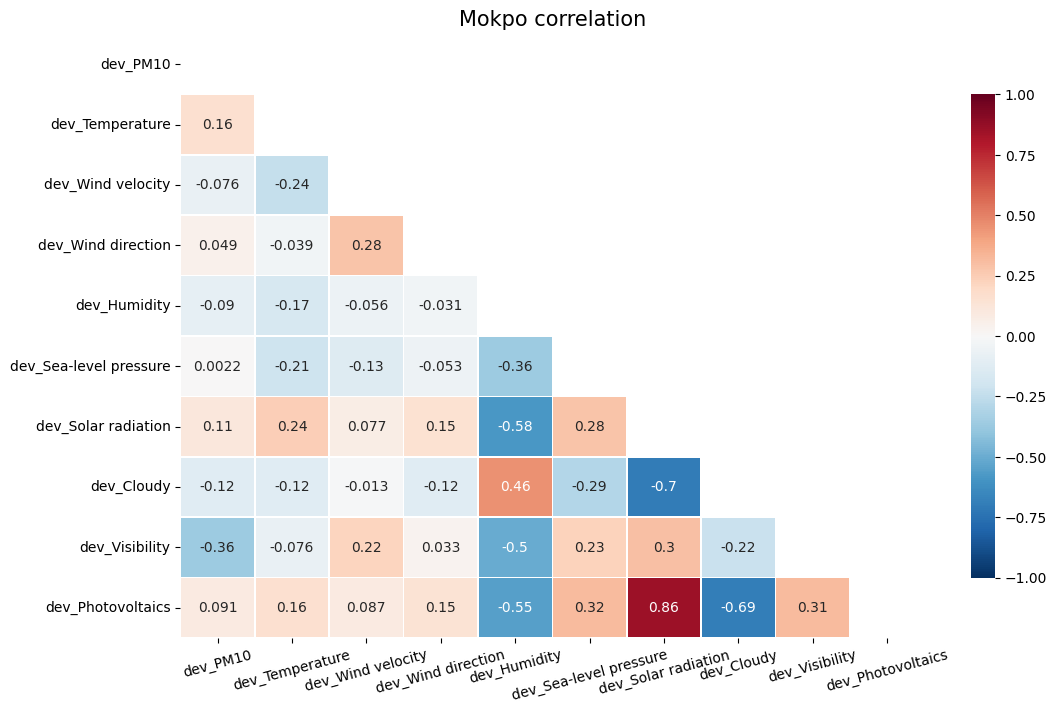

In [ ]:
c = Correlation(train_Mokpo, train_Mokpo.columns, 'Mokpo')

# Fine-tuning the model

In [ ]:
params = {}

In [ ]:
# params = GridSearch_ML(df, cols, params, dev=True)

In [ ]:
# params = GridSearch_ML(df, cols, params)

In [ ]:
params['dev_MLP'] = {'activation': 'logistic', 'hidden_layer_sizes': (300,), 'learning_rate': 'adaptive', 'max_iter': 3000, 'solver': 'adam'}
params['dev_LGBM'] = {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}
params['ori_MLP'] = {'activation': 'logistic', 'hidden_layer_sizes': (500,), 'learning_rate': 'invscaling', 'max_iter': 4000, 'solver': 'adam'}
params['ori_LGBM'] = {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}

In [ ]:
for k,v in params.items():
  print(k,v)

dev_MLP {'activation': 'logistic', 'hidden_layer_sizes': (300,), 'learning_rate': 'adaptive', 'max_iter': 3000, 'solver': 'adam'}
dev_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}
ori_MLP {'activation': 'logistic', 'hidden_layer_sizes': (500,), 'learning_rate': 'invscaling', 'max_iter': 4000, 'solver': 'adam'}
ori_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}


# Model Learning

## LR 
(LinearRegression)

In [ ]:
# score점수 저장
score = {}
# shap plot을 위한 값 저장
Shap_dic = {}

In [ ]:
pred_LR = MLTest(df, 'LR', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)

train: (3679, 9), (3679, 1) valid: (3677, 9), (3677, 1)

train: (7356, 9), (7356, 1) valid: (3677, 9), (3677, 1)

train: (11033, 9), (11033, 1) valid: (3677, 9), (3677, 1)

train: (14710, 9), (14710, 1) valid: (3677, 9), (3677, 1)

train: (18387, 9), (18387, 1) valid: (3677, 9), (3677, 1)

LinearRegression()


In [ ]:
ignore = MLTest(df, 'LR', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)

train: (3679, 9), (3679, 1) valid: (3677, 9), (3677, 1)

train: (7356, 9), (7356, 1) valid: (3677, 9), (3677, 1)

train: (11033, 9), (11033, 1) valid: (3677, 9), (3677, 1)

train: (14710, 9), (14710, 1) valid: (3677, 9), (3677, 1)

train: (18387, 9), (18387, 1) valid: (3677, 9), (3677, 1)

LinearRegression()


## MLP 
(MLPRegressor)

In [ ]:
pred_MLP = MLTest(df, 'MLP', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)

train: (3679, 9), (3679, 1) valid: (3677, 9), (3677, 1)

train: (7356, 9), (7356, 1) valid: (3677, 9), (3677, 1)

train: (11033, 9), (11033, 1) valid: (3677, 9), (3677, 1)

train: (14710, 9), (14710, 1) valid: (3677, 9), (3677, 1)

train: (18387, 9), (18387, 1) valid: (3677, 9), (3677, 1)

MLPRegressor(activation='logistic', hidden_layer_sizes=(300,),
             learning_rate='adaptive', max_iter=3000)


In [ ]:
ignore = MLTest(df, 'MLP', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)

train: (3679, 9), (3679, 1) valid: (3677, 9), (3677, 1)

train: (7356, 9), (7356, 1) valid: (3677, 9), (3677, 1)

train: (11033, 9), (11033, 1) valid: (3677, 9), (3677, 1)

train: (14710, 9), (14710, 1) valid: (3677, 9), (3677, 1)

train: (18387, 9), (18387, 1) valid: (3677, 9), (3677, 1)

MLPRegressor(activation='logistic', hidden_layer_sizes=(500,),
             learning_rate='invscaling', max_iter=4000)


## LGBM
 (LGBMRegressor)

In [ ]:
pred_LGBM = MLTest(df, 'LGBM', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)

train: (3679, 9), (3679, 1) valid: (3677, 9), (3677, 1)

train: (7356, 9), (7356, 1) valid: (3677, 9), (3677, 1)

train: (11033, 9), (11033, 1) valid: (3677, 9), (3677, 1)

train: (14710, 9), (14710, 1) valid: (3677, 9), (3677, 1)

train: (18387, 9), (18387, 1) valid: (3677, 9), (3677, 1)



In [ ]:
ignore = MLTest(df, 'LGBM', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (22064, 9), (22064, 1) test: (4325, 9), (4325, 1)

train: (3679, 9), (3679, 1) valid: (3677, 9), (3677, 1)

train: (7356, 9), (7356, 1) valid: (3677, 9), (3677, 1)

train: (11033, 9), (11033, 1) valid: (3677, 9), (3677, 1)

train: (14710, 9), (14710, 1) valid: (3677, 9), (3677, 1)

train: (18387, 9), (18387, 1) valid: (3677, 9), (3677, 1)



# Score

In [ ]:
score

{'R2_dev_LR': 0.8766670560539177,
 'RMSE_dev_LR': 137.16788847191,
 'R2_LR': 0.8034060121951435,
 'RMSE_LR': 173.18011363241354,
 'R2_dev_MLP': 0.8888328261685834,
 'RMSE_dev_MLP': 130.22704517129577,
 'R2_MLP': 0.8412801433263615,
 'RMSE_MLP': 155.60678702956906,
 'R2_dev_LGBM': 0.8927677474147777,
 'RMSE_dev_LGBM': 127.90149438162068,
 'R2_LGBM': 0.8648423613111527,
 'RMSE_LGBM': 143.5929778391137}

In [ ]:
with open('/content/gdrive/MyDrive/SolarPower/Mokpo_score.txt','w',encoding='UTF-8') as f:
  for key, values in score.items():
    f.write(f'{key}:{values}\n')

# Shap plot

In [ ]:
# 모델 학습 후 shap 생성 함수
def ShapPlot(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  shap.summary_plot(shap_values, x_train, plot_size=0.3, plot_type='bar', show=False)
  plt.title(f"{model_name} Shap barplot", fontsize=15, pad=10)
  plt.show()
  shap.summary_plot(shap_values, x_train, plot_size=0.4, show=False)
  plt.title(f"{model_name} Shap plot", fontsize=15, pad=10)
  plt.show()

Exact explainer: 22065it [06:31, 55.50it/s]


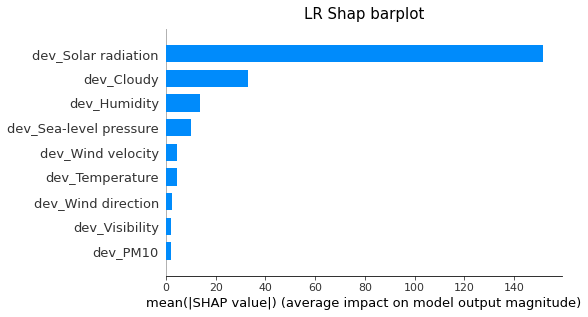

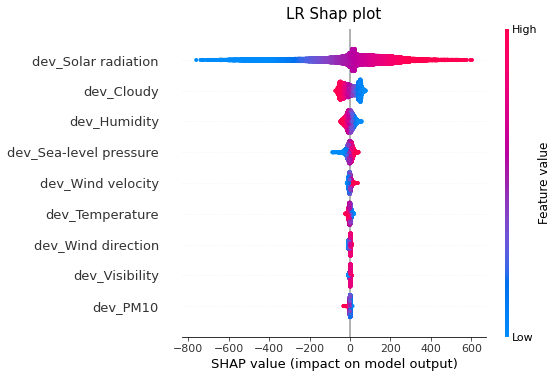

In [ ]:
ShapPlot(**Shap_dic['dev_LR'])

Exact explainer: 22065it [2:43:41,  2.24it/s]


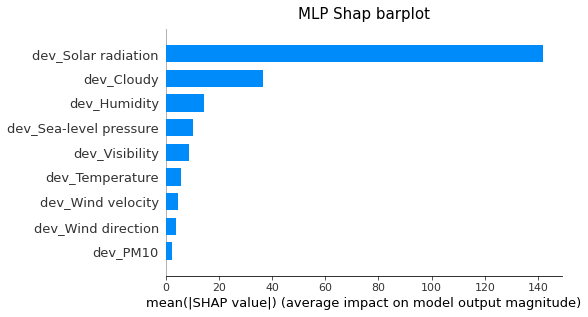

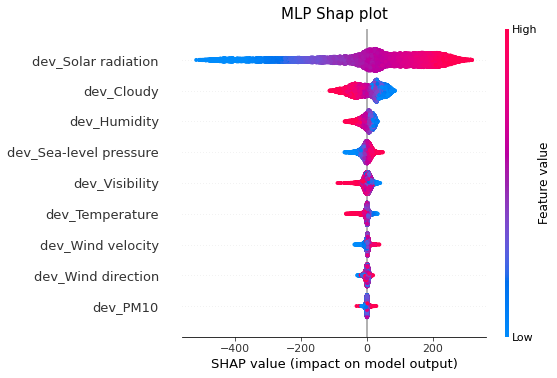

In [ ]:
ShapPlot(**Shap_dic['dev_MLP'])

Exact explainer: 22065it [1:04:35,  5.68it/s]


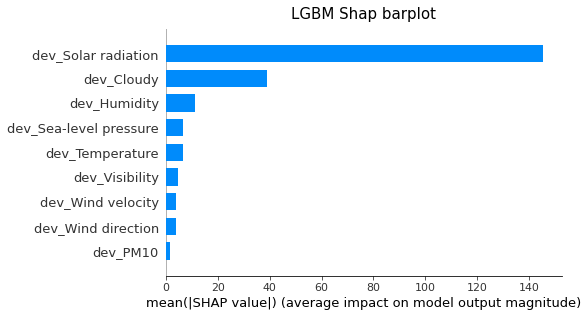

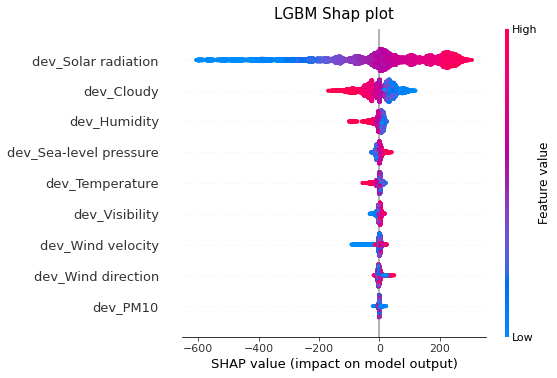

In [ ]:
ShapPlot(**Shap_dic['dev_LGBM'])

# Plot

In [ ]:
testmn

,mean_Photovoltaics
0,45.476273
1,247.181366
2,520.294013
3,741.026087
4,806.241988
...,...
4320,657.651081
4321,411.090811
4322,252.135584
4323,51.840000


In [ ]:
data = Result_pred(df, pred_LR, pred_MLP, pred_LGBM, testmn)

In [ ]:
data

,Area,Date,Month,Time,Photovoltaics,LR_Pred,MLP_Pred,LGBM_Pred,train_mean
0,전남 목포시,2019-01-01,1,9,7.32,-17.190938,-22.971370,-7.367899,45.476273
1,전남 목포시,2019-01-01,1,10,53.16,45.973834,35.993719,61.641047,247.181366
2,전남 목포시,2019-01-01,1,11,268.68,270.697654,251.910015,223.669920,520.294013
3,전남 목포시,2019-01-01,1,12,170.52,379.812885,388.572294,321.355878,741.026087
4,전남 목포시,2019-01-01,1,13,245.40,603.877790,580.358131,552.823365,806.241988
...,...,...,...,...,...,...,...,...,...
4320,전남 목포시,2019-12-31,12,14,1148.52,653.659856,641.334324,655.135753,657.651081
4321,전남 목포시,2019-12-31,12,15,830.88,639.699392,655.412574,668.395126,411.090811
4322,전남 목포시,2019-12-31,12,16,550.92,376.059368,402.053586,409.241537,252.135584
4323,전남 목포시,2019-12-31,12,17,74.28,155.567067,189.067338,160.999091,51.840000


In [ ]:
data.rename(columns={'Photovoltaics' : 'PV'}, inplace=True)

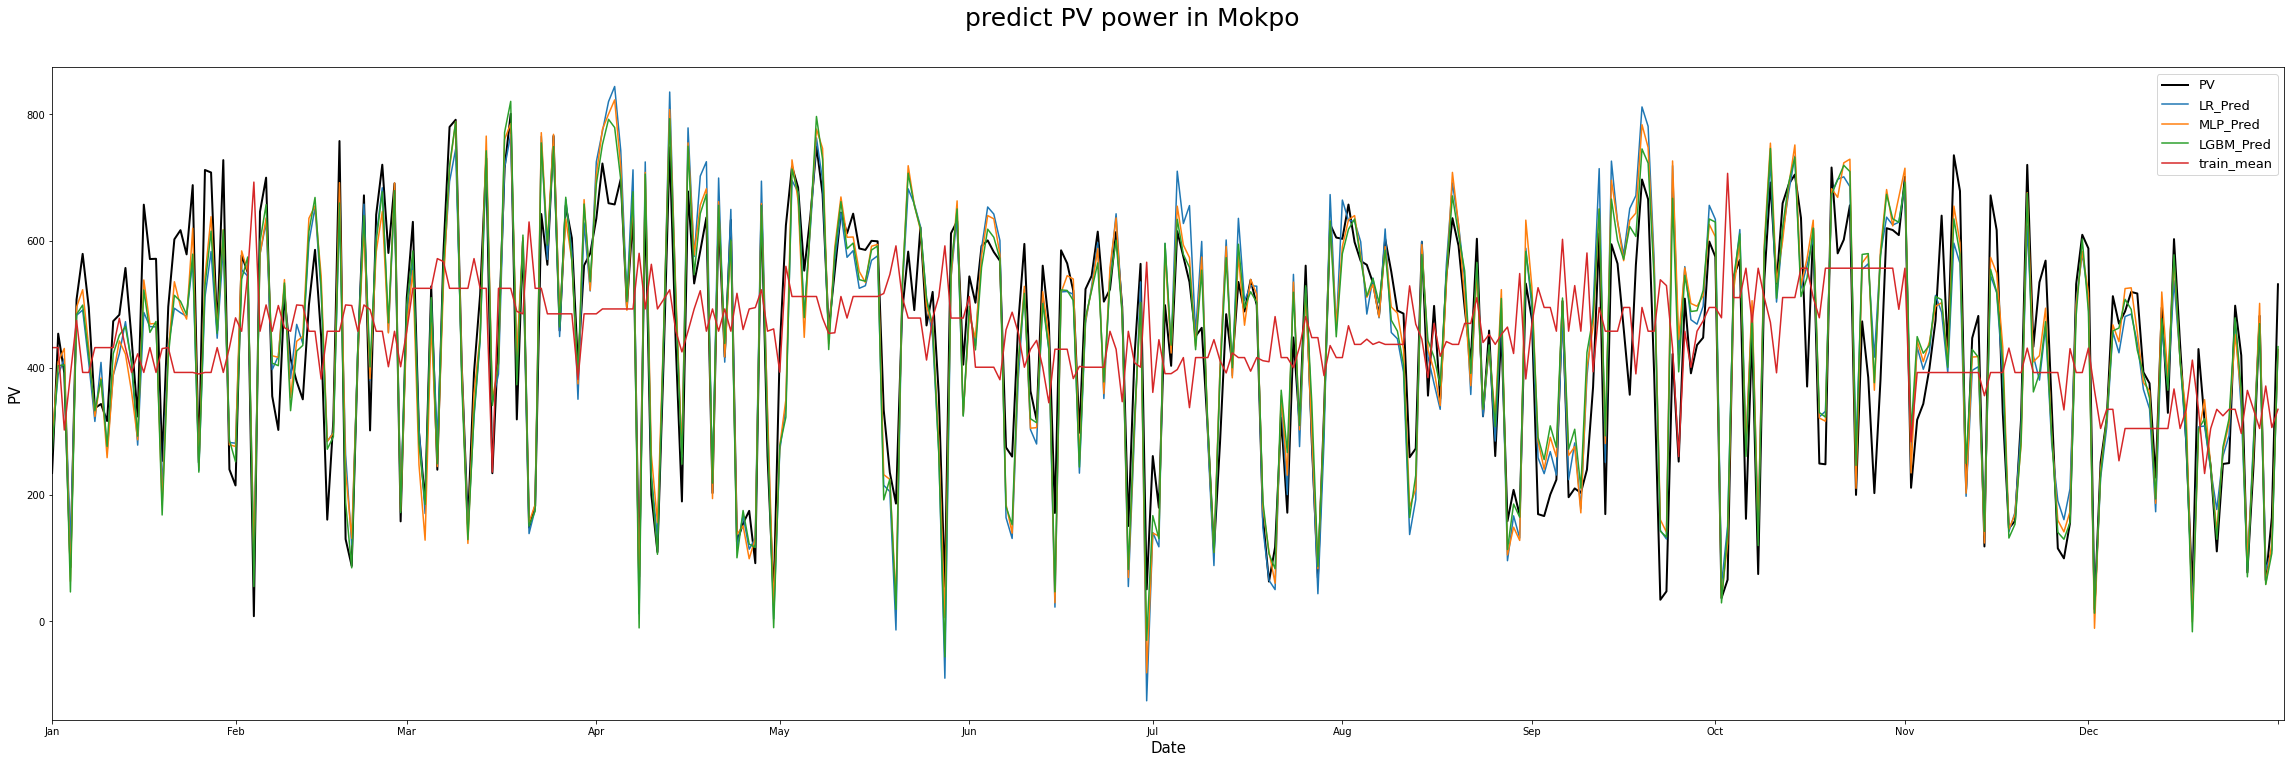

In [ ]:
Plot_Result(data, 'Mokpo')